<a href="https://colab.research.google.com/github/mc-off/ML/blob/main/titanic/titanic_is_dead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
#core
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

#models
from collections import OrderedDict
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier

#model selection
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, KFold, cross_val_score, GridSearchCV

#plots
from matplotlib import style
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#preprocessing
import re
from sklearn.preprocessing import LabelEncoder

#utils
import logging
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from google.colab import drive
from numpy import array
import warnings
import time
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


##Data

###Preprocess

In [4]:
abbreviatures = ['Dr', 'Esq', 'Hon', 'Jr', 'Mr', 'Mrs', 'Ms', 'Messrs', 'Mmes', 'Msgr', 'Prof', 'Rev', 'Sr', 'St', 'Master', 'Miss']

In [5]:
pd.set_option("display.max_rows", 100, "display.max_columns", None)

In [6]:
def checkAbbreviature(array):
      returnValue = 'Extra'
      for value in array:
        if value in abbreviatures:
          returnValue = value
      return returnValue

In [7]:
encoder = LabelEncoder()
def prepocesse (df):
  #Name preprocess
  df.Name = df.Name.apply(lambda l: re.sub('\W+',' ', l ))
  df.Name = df.Name.apply(lambda l: l.split(" "))
  df.Name = df.Name.apply(lambda l: checkAbbreviature(l))
  df.Name = encoder.fit_transform(df.Name.astype(str))

  #Cabin prerpocess
  df.Cabin = df.Cabin.isna()
  df.Cabin = encoder.fit_transform(df.Cabin)

  #Age preprocess
  df.Age.fillna(-1, inplace=True)
  df.Age = df.Age.astype(int)

  #Sex encoder
  df.Sex= encoder.fit_transform(df.Sex)

  #Embarked encoder
  df.Embarked = encoder.fit_transform(df.Embarked.astype(str))
  df.Embarked.fillna((df.Embarked.mode()),inplace = True)

  #Fare encoder
  df.Fare = df.Fare.apply(lambda l: round(l,0))
  df.Fare.fillna((df.Fare.mean()),inplace = True)

  #Drop unneccesary columns
  df.drop(labels=['PassengerId', 'Ticket'], axis=1, inplace=True)
  return df

#### Preprocess flow or how this function above was generated

In [79]:
df_train = pd.read_csv('/content/drive/My Drive/data/titanic/train.csv')

In [64]:
df_train.isna()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,True,False,False,False,False,True,False
889,False,False,False,False,False,False,False,False,False,False,False,False


In [65]:
df_train.columns[df_train.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

Some tricks with age

In [66]:
df_train.Age[df_train.Age.isna()]

5     NaN
17    NaN
19    NaN
26    NaN
28    NaN
       ..
859   NaN
863   NaN
868   NaN
878   NaN
888   NaN
Name: Age, Length: 177, dtype: float64

So, i supposed that age value could be also affect without binnar separation and in preparation i replace nan values with -1

What about cabin:
I dont wanna here use string lemmantizations, so i decide just use binare set of cabin where 0 - nan value and 1 - another else.

In [68]:
df_train.Cabin[df_train.Cabin.isna()]

0      NaN
2      NaN
4      NaN
5      NaN
7      NaN
      ... 
884    NaN
885    NaN
886    NaN
888    NaN
890    NaN
Name: Cabin, Length: 687, dtype: object

The most insteresting one - Names
Firsly, need to clear strigng from spec characters

In [80]:
df_train_copy = df_train.copy()

In [81]:
df_train_copy

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [82]:
df_train_copy.Name = df_train_copy.Name.apply(lambda l: re.sub('\W+',' ', l ))
df_train_copy.Name = df_train_copy.Name.apply(lambda l: l.split(" "))
df_train_copy.Name

0                             [Braund, Mr, Owen, Harris]
1      [Cumings, Mrs, John, Bradley, Florence, Briggs...
2                               [Heikkinen, Miss, Laina]
3      [Futrelle, Mrs, Jacques, Heath, Lily, May, Pee...
4                            [Allen, Mr, William, Henry]
                             ...                        
886                              [Montvila, Rev, Juozas]
887                      [Graham, Miss, Margaret, Edith]
888         [Johnston, Miss, Catherine, Helen, Carrie, ]
889                             [Behr, Mr, Karl, Howell]
890                                [Dooley, Mr, Patrick]
Name: Name, Length: 891, dtype: object

Then, got list of titles from https://www.btb.termiumplus.gc.ca/tpv2guides/guides/wrtps/index-eng.html?lang=eng&lettr=indx_catlog_a&page=9NBnYuQ324Yc.html and got:

In [83]:
abbreviatures = ['Dr', 'Esq', 'Hon', 'Jr', 'Mr', 'Mrs', 'Ms', 'Messrs', 'Mmes', 'Msgr', 'Prof', 'Rev', 'Sr', 'St']

In [88]:
def checkAbbreviature(array):
      returnValue = np.nan
      for value in array:
        if value in abbreviatures:
          returnValue = value
      return returnValue

In [93]:
df_train_copy.Name[df_train_copy.Name.apply(lambda l: checkAbbreviature(l)).isna()]

2                          [Heikkinen, Miss, Laina]
7                 [Palsson, Master, Gosta, Leonard]
10               [Sandstrom, Miss, Marguerite, Rut]
11                       [Bonnell, Miss, Elizabeth]
14         [Vestrom, Miss, Hulda, Amanda, Adolfina]
                           ...                     
869              [Johnson, Master, Harold, Theodor]
875            [Najib, Miss, Adele, Kiamie, Jane, ]
882                 [Dahlberg, Miss, Gerda, Ulrika]
887                 [Graham, Miss, Margaret, Edith]
888    [Johnston, Miss, Catherine, Helen, Carrie, ]
Name: Name, Length: 229, dtype: object

In [94]:
df_train[df_train_copy.Name.apply(lambda l: checkAbbreviature(l)).isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
869,870,1,3,"Johnson, Master. Harold Theodor",male,4.0,1,1,347742,11.1333,NaN,S
875,876,1,3,"Najib, Miss. Adele Kiamie ""Jane""",female,15.0,0,0,2667,7.2250,NaN,C
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S


Wow wow, not so much, okay, we just lost something special

After some researches, i consider that we lost Master and Miss

In [99]:
abbreviatures = ['Dr', 'Esq', 'Hon', 'Jr', 'Mr', 'Mrs', 'Ms', 'Messrs', 'Mmes', 'Msgr', 'Prof', 'Rev', 'Sr', 'St', 'Master', 'Miss']

Let's check what we missed now

In [100]:
df_train_copy.Name[df_train_copy.Name.apply(lambda l: checkAbbreviature(l)).isna()]

30                           [Uruchurtu, Don, Manuel, E]
369                     [Aubart, Mme, Leontine, Pauline]
449                    [Peuchen, Major, Arthur, Godfrey]
536                 [Butt, Major, Archibald, Willingham]
641                               [Sagesser, Mlle, Emma]
647              [Simonius, Blumer, Col, Oberst, Alfons]
694                                    [Weir, Col, John]
745                      [Crosby, Capt, Edward, Gifford]
759    [Rothes, the, Countess, of, Lucy, Noel, Martha...
822                   [Reuchlin, Jonkheer, John, George]
Name: Name, dtype: object

In [101]:
df_train[df_train_copy.Name.apply(lambda l: checkAbbreviature(l)).isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3000,B35,C
449,450,1,1,"Peuchen, Major. Arthur Godfrey",male,52.0,0,0,113786,30.5000,C104,S
536,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.5500,B38,S
641,642,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.3000,B35,C
647,648,1,1,"Simonius-Blumer, Col. Oberst Alfons",male,56.0,0,0,13213,35.5000,A26,C
694,695,0,1,"Weir, Col. John",male,60.0,0,0,113800,26.5500,NaN,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0000,B22,S
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,B77,S
822,823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0000,NaN,S


Much better!
So, just replace them with some **Extra** value

With fare is yzy: just use mean within NaN values

In [103]:
df_train.Fare = df_train.Fare.apply(lambda l: round(l,0))
df_train.Fare.fillna((df_train.Fare.mean()),inplace = True)
df_train.Fare

0       7.0
1      71.0
2       8.0
3      53.0
4       8.0
       ... 
886    13.0
887    30.0
888    23.0
889    30.0
890     8.0
Name: Fare, Length: 891, dtype: float64

In [105]:
df_train.Fare[df_train.Fare.isna()]

Series([], Name: Fare, dtype: float64)

Also, i used label encoders within str values. 
What's all

###Import data

In [107]:
df_train = prepocesse(pd.read_csv('/content/drive/My Drive/data/titanic/train.csv'))

In [108]:
df_train.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,4,1,22,1,0,7.0,1,2
1,1,1,5,0,38,1,0,71.0,0,0
2,1,3,3,0,26,0,0,8.0,1,2
3,1,1,5,0,35,1,0,53.0,0,2
4,0,3,4,1,35,0,0,8.0,1,2
5,0,3,4,1,-1,0,0,8.0,1,1
6,0,1,4,1,54,0,0,52.0,0,2
7,0,3,2,1,2,3,1,21.0,1,2
8,1,3,5,0,27,0,2,11.0,1,2
9,1,2,5,0,14,1,0,30.0,1,0


## ML Algorithms

Section with algos for ML. List:


*   KNN
*   Naive Bayes
*   SVM
*   Random Forest
*   Decision Tree
*   AdaBoost

For each of algos there is paramater to run with/without greed search. On function callm also printed plot and metrics. 







###Tools

In [34]:
def fit_pred_plot(X_train, X_test, target_train, target_test, model, name):
  model.fit(X_train, target_train)
  predicted = model.predict(X_test)

  fig, ax = plt.subplots(1, 1, figsize=(17, 9))
  
  ax.plot(predicted, "b-", label="Predicted")
  ax.plot(target_test.values, "r-", label="True")
  ax.set_title(name)
  ax.label_outer()
  plt.legend(loc="best")
  fig.show()

  acc = metrics.accuracy_score(y_true=target_test, y_pred=predicted)
  report = metrics.classification_report(
      y_true=target_test,
      y_pred=predicted,
      target_names=["0", "1"])
  print(report)
  print("    accuracy      %0.3f" % acc)
  return round(acc, 3)

### KNN

In [45]:
def knn_grid_search(X,Y):
  params = {'n_neighbors': [1,3,5,13,15,20,50,100],
            'weights': ['uniform','distance'],
            'metric':['euclidean','manhattan']}
  knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, n_jobs=10, cv=5, verbose=1, scoring='accuracy')
  knn_grid.fit(X,Y)
  return knn_grid.best_params_


def knn_on_df(df, target, isGridSearch=True):
  X_train, X_test, target_train, target_test = train_test_split(df, target, test_size=0.3, random_state=33)
  if (isGridSearch):
    start = time.time()
    best_params = knn_grid_search(X_train, target_train)
    finish = time.time()
    print(f"Finished in: {finish - start}")
    print(best_params)
    knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'],weights=best_params['weights'],metric=best_params['metric'])
  else:
    knn = KNeighborsClassifier()
  fit_pred_plot(X_train, X_test, target_train, target_test, knn, 'KNN')


### Naive Bayes


In [36]:
def naive_bayes_grid_search(X,Y):
  params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
  nb_grid = GridSearchCV(BernoulliNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
  nb_grid.fit(X,Y)
  return nb_grid.best_params_


def naive_bayes_on_df(df, target, isGridSearch=True):
  X_train, X_test, target_train, target_test = train_test_split(df, target, test_size=0.3, random_state=33)
  if (isGridSearch):
    start = time.time()
    best_params = naive_bayes_grid_search(X_train, target_train)
    finish = time.time()
    print(f"Finished in: {finish - start}")
    print(best_params)
    nb = BernoulliNB()
  else:
    nb = BernoulliNB()
  fit_pred_plot(X_train, X_test, target_train, target_test, nb, 'Naive Bayes')



### SVM


In [37]:
def svm_greed_search(X, y, nfolds):
  svc = SVC()
  grid_values = {'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'C': [0.1, 0.2, 0.3, 0.4, 0.5,0.7,0.9]}
  grid_svc_acc = GridSearchCV(svc, param_grid = grid_values, cv=nfolds)
  grid_svc_acc.fit(X, y)
  return grid_svc_acc.best_params_

def svm_on_df(df, target, isGridSearch=True):
  X_train, X_test, target_train, target_test = train_test_split(df, target, test_size=0.3, random_state=33)
  if (isGridSearch):
    start = time.time()
    best_params = svm_greed_search(X_train, target_train, 5)
    finish = time.time()
    print(f"Finished in: {finish - start}")
    print(best_params)
    svc = SVC(kernel=best_params['kernel'], C=best_params['C'])
  else:
    svc = SVC()
  fit_pred_plot(X_train, X_test, target_train, target_test, svc, 'SVM')

### Random Forest

In [112]:
def random_forest_grid_search(X, y, nfolds):
    param_grid = { 'criterion':['gini','entropy'],'max_features':['log2','auto','sqrt'], 'criterion':['gini','entropy'], 'bootstrap': [True, False], 'n_estimators' : [10,50,100,500,1000]}
    model=RandomForestClassifier()
    model_gscv = GridSearchCV(model, param_grid, cv=nfolds)
    model_gscv.fit(X, y)
    return model_gscv.best_params_

def random_forest_on_df(df, target, isGridSearch=True):
  X_train, X_test, target_train, target_test = train_test_split(df, target, test_size=0.3, random_state=33)
  if (isGridSearch):
    start = time.time()
    best_params = random_forest_grid_search(X_train, target_train, 5)
    finish = time.time()
    print(f"Finished in: {finish - start}")
    print(best_params)
    rf = RandomForestClassifier(n_estimators = best_params['n_estimators'], max_features = best_params['max_features'], criterion=best_params["criterion"], random_state=33, bootstrap=best_params["bootstrap"],verbose=1)
  else:
    rf = RandomForestClassifier()
  fit_pred_plot(X_train, X_test, target_train, target_test, rf, 'Random Forest')


### Decision Tree

In [39]:
def dtree_grid_search(X, y, nfolds):
    param_grid = { 'criterion':['gini','entropy'],'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': list(range(1,10)), 'max_leaf_nodes':list(range(3,30))}
    dtree_model=DecisionTreeClassifier()
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds, scoring='accuracy')
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

def decision_tree_on_df(df, target, isGridSearch=True):
  X_train, X_test, target_train, target_test = train_test_split(df, target, test_size=0.3, random_state=33)
  if (isGridSearch):
      start = time.time()
      best_params = dtree_grid_search(X_train, target_train, 5)
      finish = time.time()
      print(f"Finished in: {finish - start}")
      print(best_params)
      dt = DecisionTreeClassifier(criterion=best_params["criterion"],max_features=best_params["max_features"], max_depth=best_params["max_depth"], max_leaf_nodes=best_params["max_leaf_nodes"])
  else:
      dt = DecisionTreeClassifier()
  fit_pred_plot(X_train, X_test, target_train, target_test, dt, 'Decision Tree')

###ADABOOST

In [40]:
def adaboost_greed_search(X, Y):
  params =  {'n_estimators':[1,3,7,10, 20, 50, 100, 200, 500], 'learning_rate':[0.001, 0.01, 0.1, 0.2, 0.5, 0.9]}
  ab_gscv = GridSearchCV(AdaBoostClassifier(), params, cv=5)
  ab_gscv.fit(X,Y)
  return ab_gscv.best_params_

def adaboost(df, target, isGridSearch=True):
  X_train, X_test, target_train, target_test = train_test_split(df, target, test_size=0.3, random_state=33)
  if (isGridSearch):
    start = time.time()
    best_params = adaboost_greed_search(X_train, target_train)
    finish = time.time()
    print(f"Finished in: {finish - start}")
    print(best_params)
    ab = AdaBoostClassifier(n_estimators =best_params['n_estimators'], learning_rate=best_params['learning_rate'])
  else:
    ab = AdaBoostClassifier()
  fit_pred_plot(X_train, X_test, target_train, target_test, ab, 'ADABOOST')

##Tests

###KNN
max_acc 0.765

####With GS
accuracy      0.765

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 141 out of 160 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=10)]: Done 160 out of 160 | elapsed:    1.3s finished


Finished in: 1.3015384674072266
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       164
           1       0.75      0.60      0.66       104

    accuracy                           0.76       268
   macro avg       0.76      0.73      0.74       268
weighted avg       0.76      0.76      0.76       268

    accuracy      0.765


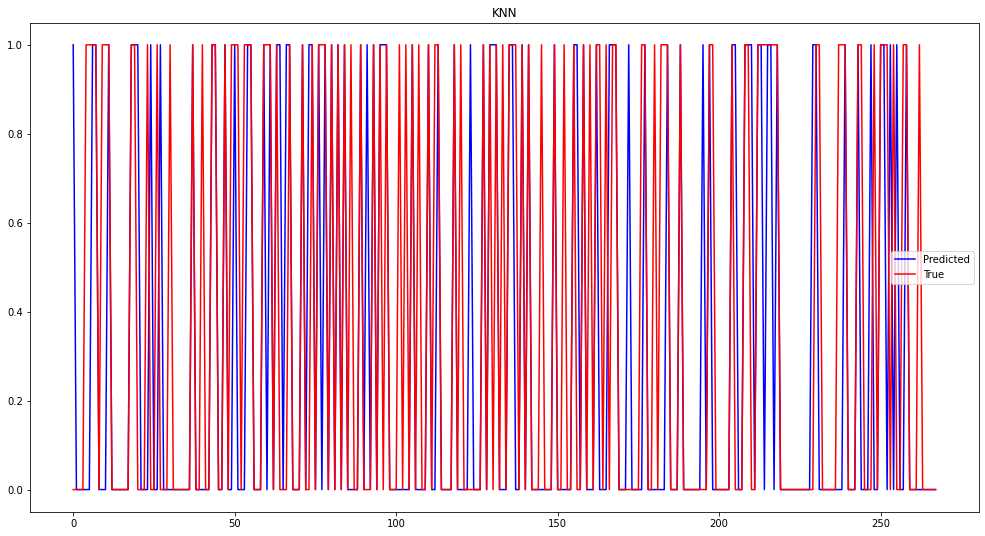

In [46]:
knn_on_df(df_train.drop(['Survived'], axis=1),df_train.Survived, isGridSearch=True)

####Without GS
accuracy      0.675

              precision    recall  f1-score   support

           0       0.71      0.80      0.75       164
           1       0.60      0.48      0.53       104

    accuracy                           0.68       268
   macro avg       0.66      0.64      0.64       268
weighted avg       0.67      0.68      0.67       268

    accuracy      0.675


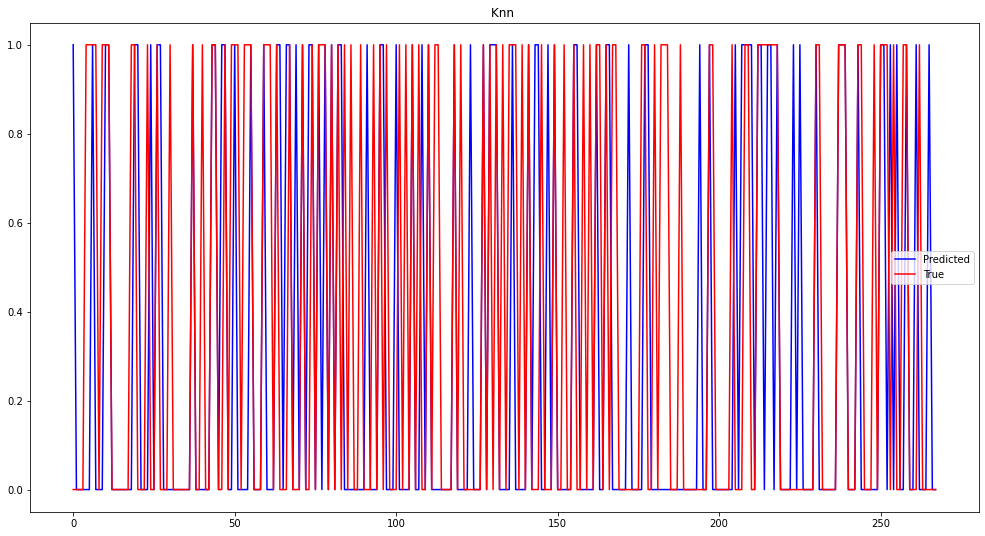

In [ ]:
knn_on_df(df_train.drop(['Survived'], axis=1),df_train.Survived, isGridSearch=False)

###Naive bayes
max_acc=0.802

####With GS
accuracy      0.802

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Finished in: 0.13974428176879883
{'alpha': 0.01}
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       164
           1       0.73      0.79      0.76       104

    accuracy                           0.80       268
   macro avg       0.79      0.80      0.79       268
weighted avg       0.81      0.80      0.80       268

    accuracy      0.802


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


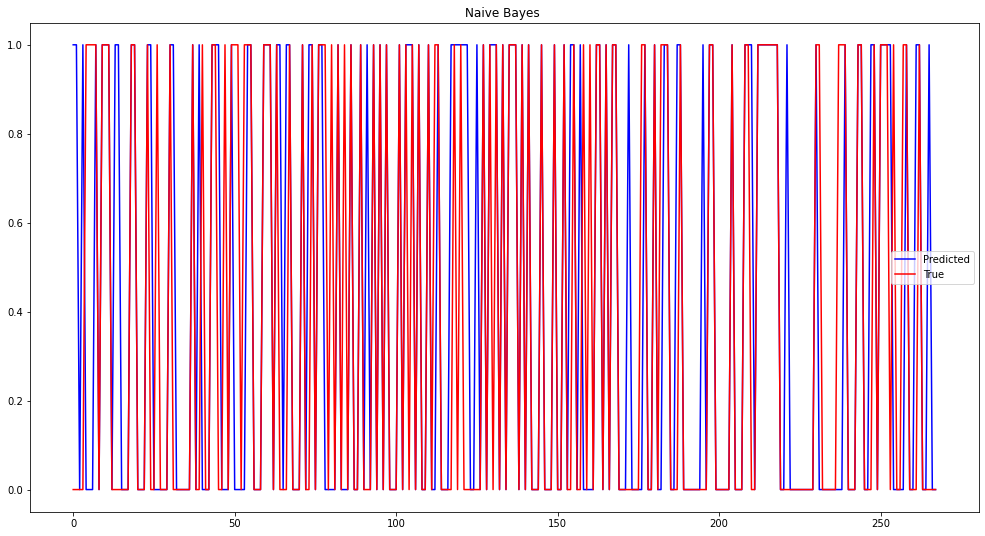

In [ ]:
naive_bayes_on_df(df_train.drop(['Survived'], axis=1),df_train.Survived, isGridSearch=True)

####Without GS

accuracy      0.802

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       164
           1       0.73      0.79      0.76       104

    accuracy                           0.80       268
   macro avg       0.79      0.80      0.79       268
weighted avg       0.81      0.80      0.80       268

    accuracy      0.802


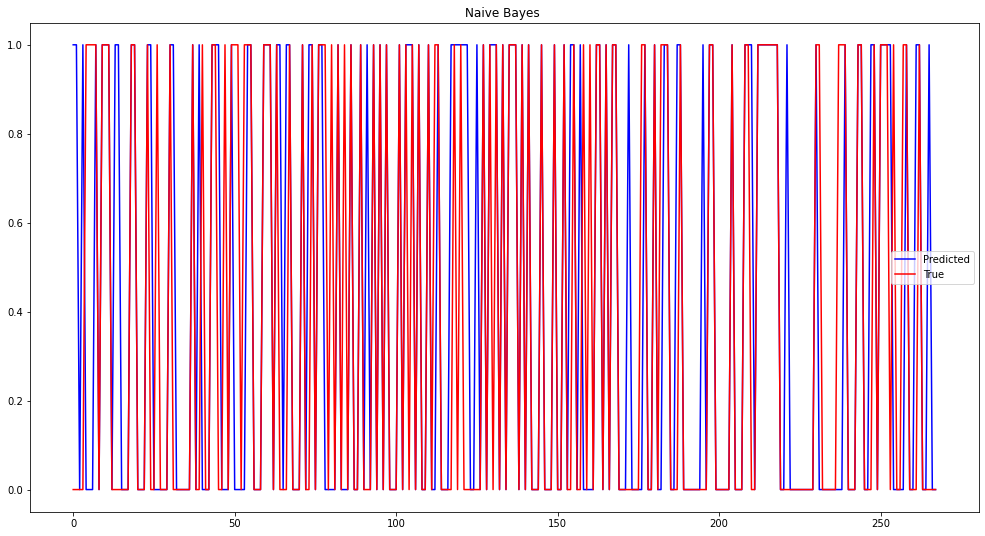

In [ ]:
naive_bayes_on_df(df_train.drop(['Survived'], axis=1),df_train.Survived, isGridSearch=False)

###Random forest
max_acc = 0.858

####With GS
 accuracy      0.854

Where wew a version with range line (10,1000,10), but after colab session crashes and computing were breaked, range was replaced with [10,50,100,500,1000]

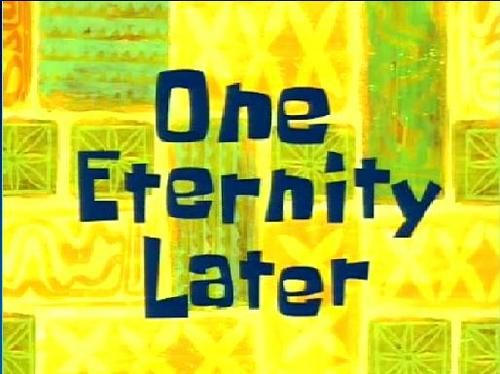

Finished in: 150.64656281471252
{'bootstrap': True, 'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       164
           1       0.83      0.79      0.81       104

    accuracy                           0.85       268
   macro avg       0.85      0.84      0.85       268
weighted avg       0.85      0.85      0.85       268

    accuracy      0.854


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


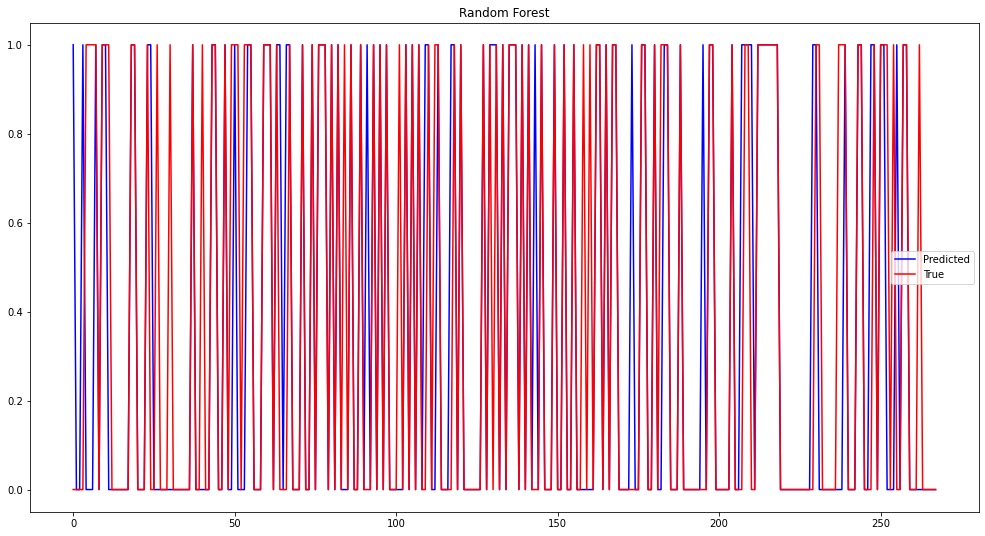

In [113]:
random_forest_on_df(df_train.drop(['Survived'], axis=1),df_train.Survived, isGridSearch=True)

####Without GS
accuracy      0.858

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       164
           1       0.84      0.78      0.81       104

    accuracy                           0.86       268
   macro avg       0.86      0.84      0.85       268
weighted avg       0.86      0.86      0.86       268

    accuracy      0.858


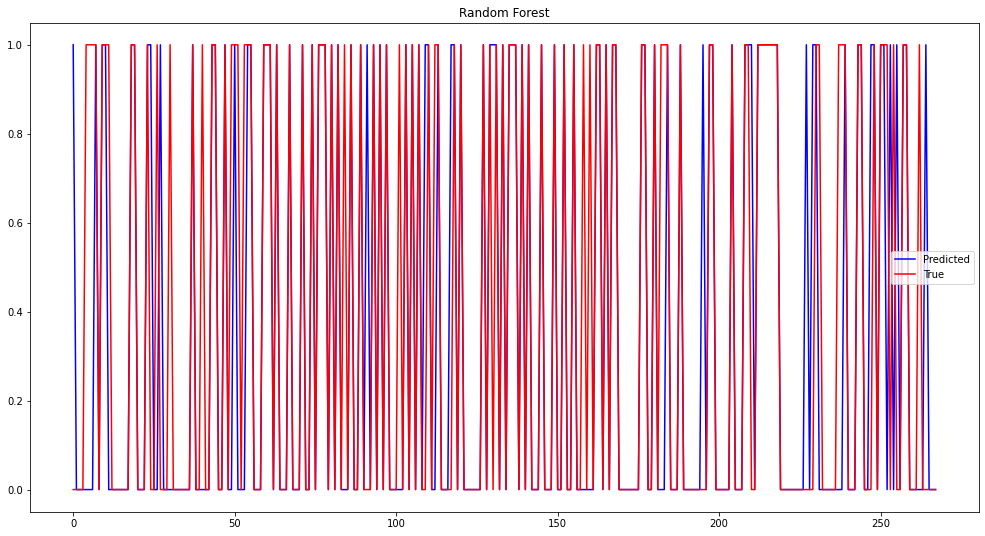

In [ ]:
random_forest_on_df(df_train.drop(['Survived'], axis=1),df_train.Survived, isGridSearch=False)

####OOB
resource: https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py

In [12]:
# Generate a binary classification dataset.
X, y = make_classification(n_samples=500, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=33)

In [23]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=33)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=33)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=33))
]

In [24]:
# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

In [25]:
# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 1000

In [26]:
for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

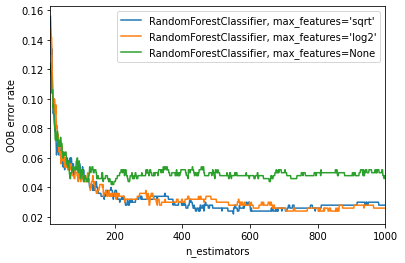

In [28]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [30]:
X_train, X_test, target_train, target_test = train_test_split(df_train.drop(['Survived'], axis=1),df_train.Survived, test_size=0.3, random_state=33)

In [114]:
def grid_search_rf_for_oob(feature):
  params = { 'max_features':[feature]}
  rf_grid = GridSearchCV(RandomForestClassifier(), params, cv=5)
  rf_grid.fit(X_train, target_train)
  print(f' Best params {rf_grid.best_params_}') 
  return rf_grid.best_params_

 Best params {'max_features': 'sqrt'}
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       164
           1       0.84      0.78      0.81       104

    accuracy                           0.86       268
   macro avg       0.86      0.84      0.85       268
weighted avg       0.86      0.86      0.86       268

    accuracy      0.858


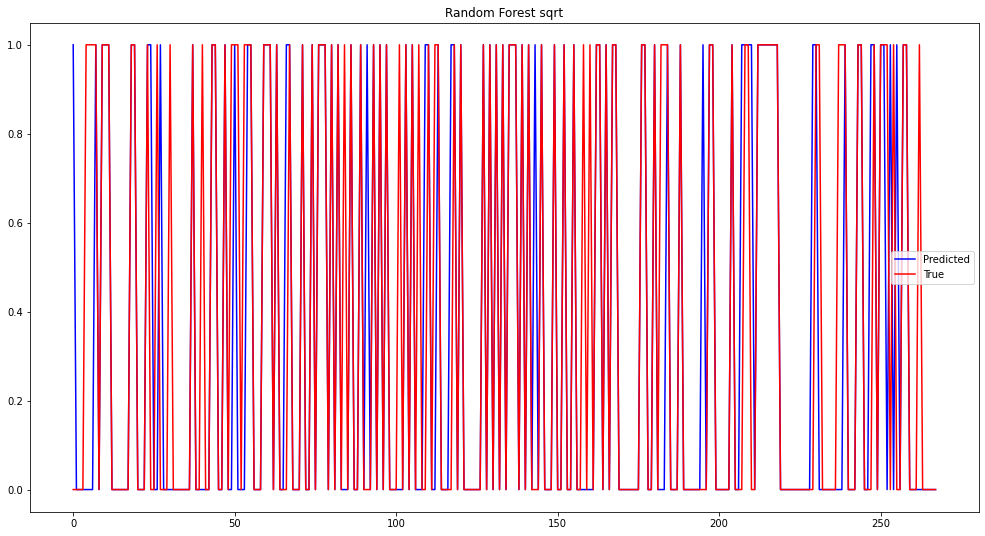

In [115]:
best_params = grid_search_rf_for_oob('sqrt') 
rf = RandomForestClassifier(criterion = 'gini', oob_score=True,  n_estimators =50, max_features= best_params['max_features'])
rf_sqrt = fit_pred_plot(X_train, X_test, target_train, target_test, rf, name = 'Random Forest sqrt')

 Best params {'max_features': 'log2'}
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       164
           1       0.84      0.78      0.81       104

    accuracy                           0.86       268
   macro avg       0.86      0.84      0.85       268
weighted avg       0.86      0.86      0.86       268

    accuracy      0.858


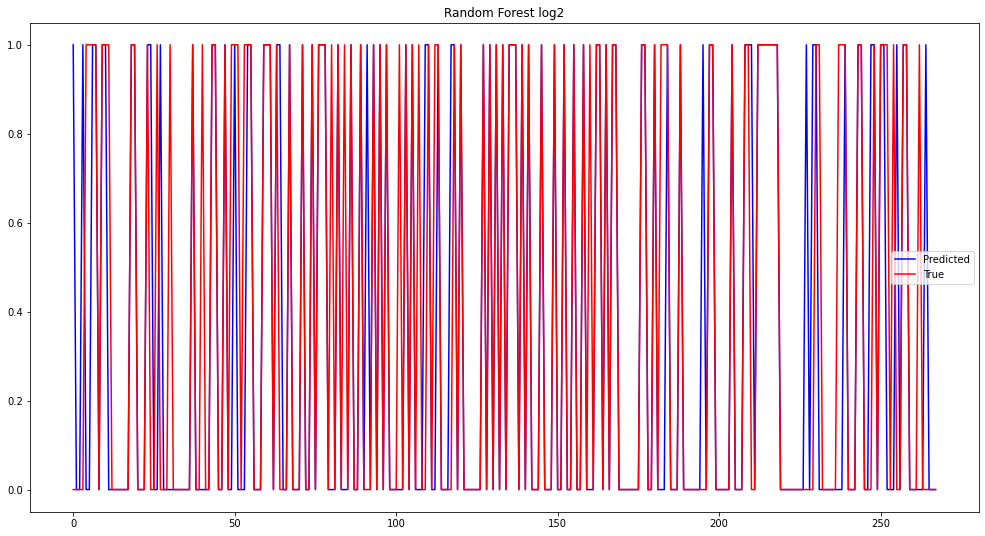

In [124]:
best_params = grid_search_rf_for_oob('log2') 
rf = RandomForestClassifier(criterion = 'gini', oob_score=True,  n_estimators =50, max_features= best_params['max_features'])
rf_sqrt = fit_pred_plot(X_train, X_test, target_train, target_test, rf, name = 'Random Forest log2')

 Best params {'max_features': 'auto'}
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       164
           1       0.83      0.78      0.80       104

    accuracy                           0.85       268
   macro avg       0.85      0.84      0.84       268
weighted avg       0.85      0.85      0.85       268

    accuracy      0.851


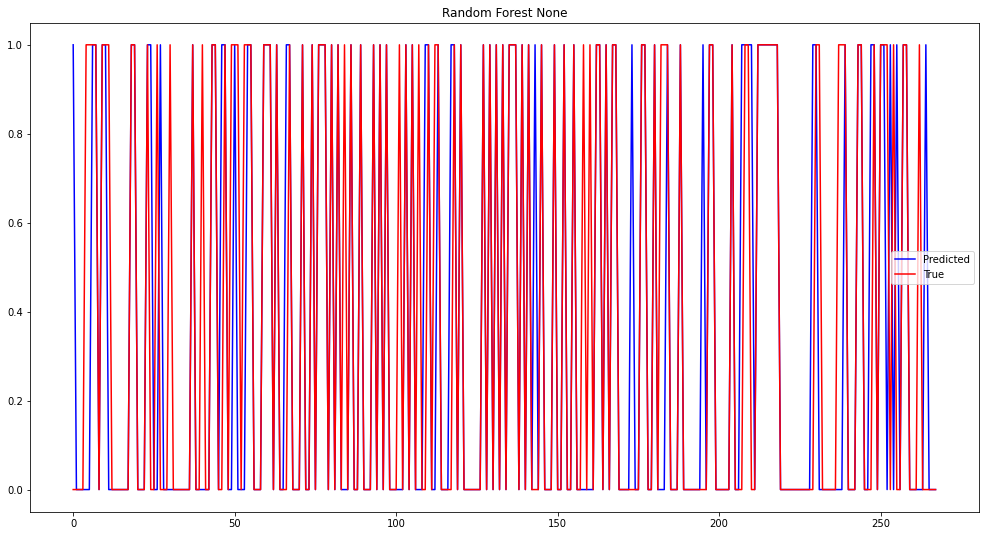

In [118]:
best_params = grid_search_rf_for_oob('auto') 
rf = RandomForestClassifier(criterion = 'gini', oob_score=True,  n_estimators =50, max_features= best_params['max_features'])
rf_sqrt = fit_pred_plot(X_train, X_test, target_train, target_test, rf, name = 'Random Forest None')

###Desicion tree
max_acc 0.825

####With GS
accuracy: 0.806

Finished in: 24.009776830673218
{'criterion': 'entropy', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': 15}
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       164
           1       0.71      0.84      0.77       104

    accuracy                           0.81       268
   macro avg       0.80      0.81      0.80       268
weighted avg       0.82      0.81      0.81       268

    accuracy      0.806


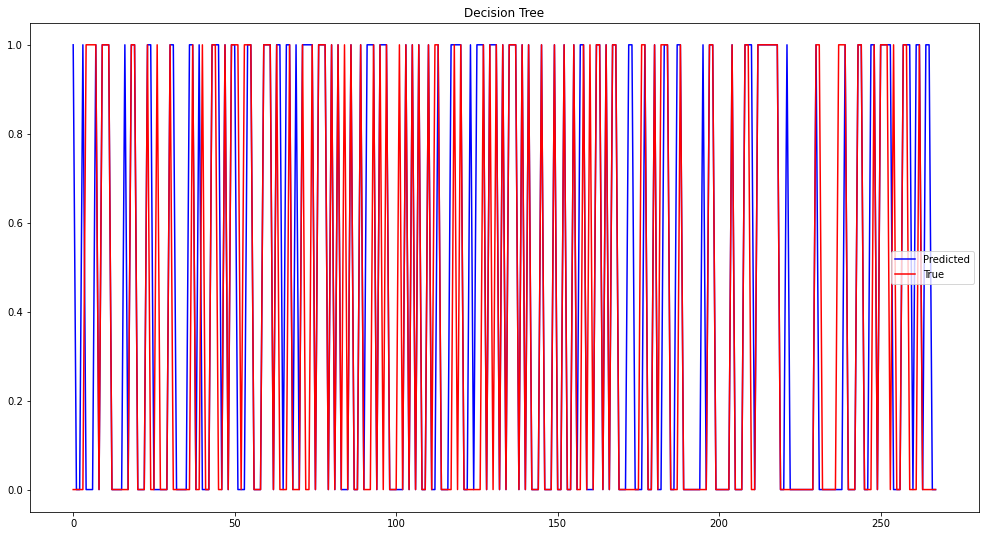

In [ ]:
decision_tree_on_df(df_train.drop(['Survived'], axis=1),df_train.Survived, isGridSearch=True)

####Without GS
accuracy      0.825


              precision    recall  f1-score   support

           0       0.84      0.88      0.86       164
           1       0.80      0.73      0.76       104

    accuracy                           0.82       268
   macro avg       0.82      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268

    accuracy      0.825


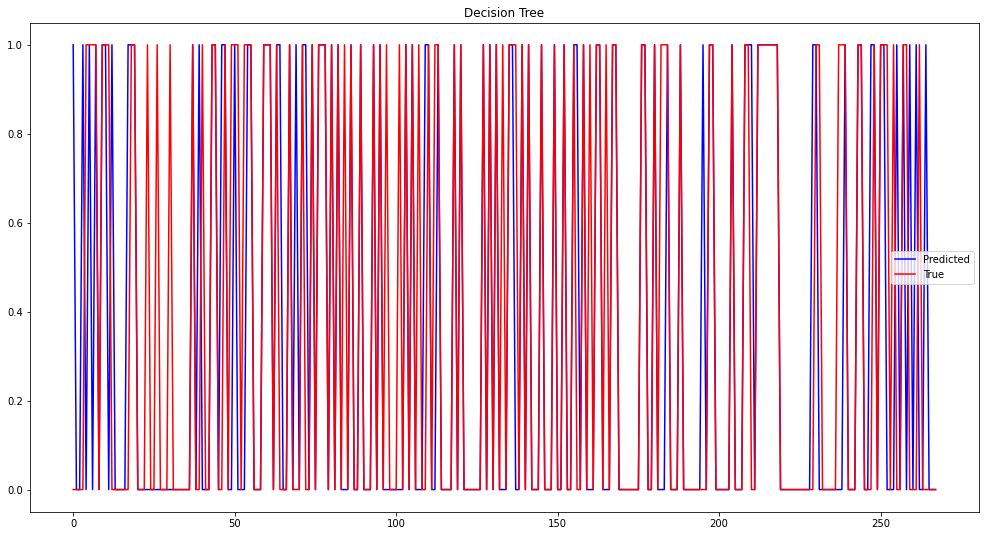

In [ ]:
decision_tree_on_df(df_train.drop(['Survived'], axis=1),df_train.Survived, isGridSearch=False)

###SVM
max_acc=0.810

####With GS
accuracy: 0.810

Finished in: 13.90160870552063
{'C': 0.4, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       164
           1       0.77      0.73      0.75       104

    accuracy                           0.81       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268

    accuracy      0.810


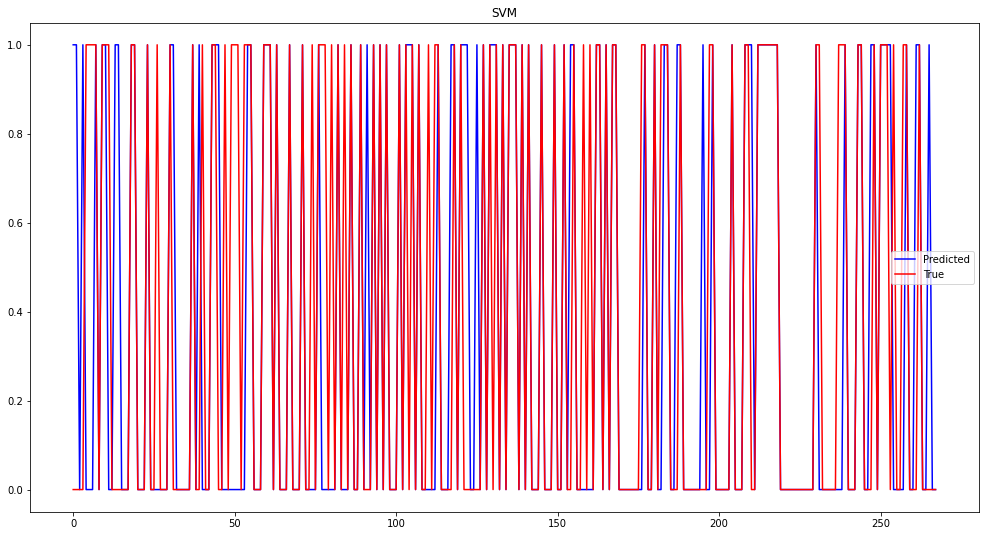

In [ ]:
svm_on_df(df_train.drop(['Survived'], axis=1),df_train.Survived, isGridSearch=True)

####Without GS
accuracyL 0.675

              precision    recall  f1-score   support

           0       0.67      0.91      0.77       164
           1       0.68      0.31      0.42       104

    accuracy                           0.68       268
   macro avg       0.68      0.61      0.60       268
weighted avg       0.68      0.68      0.64       268

    accuracy      0.675


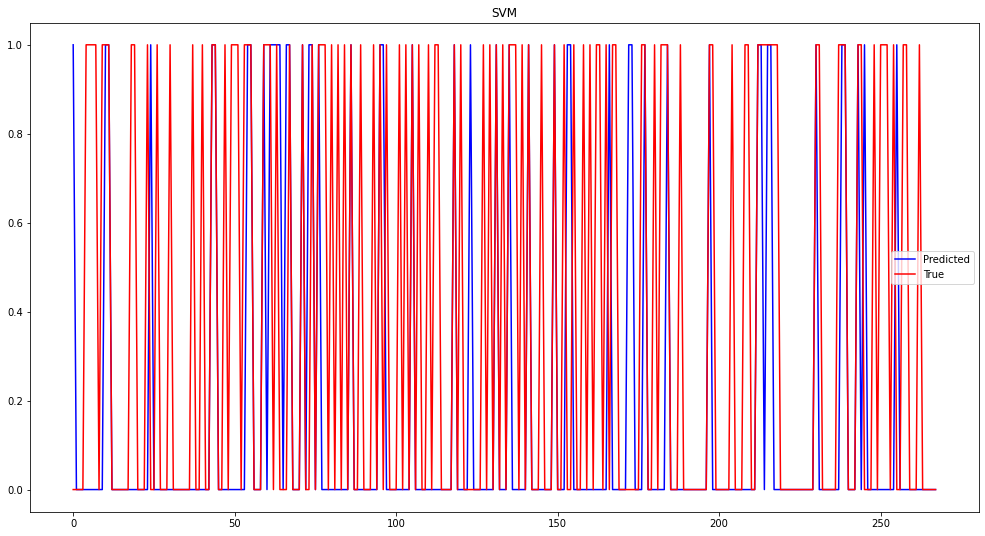

In [ ]:
svm_on_df(df_train.drop(['Survived'], axis=1),df_train.Survived, isGridSearch=False)

###AdaBoost
max_acc:0.854

####With GS
accuracy 0.854

Finished in: 44.26434659957886
{'learning_rate': 0.9, 'n_estimators': 20}
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       164
           1       0.82      0.81      0.81       104

    accuracy                           0.85       268
   macro avg       0.85      0.85      0.85       268
weighted avg       0.85      0.85      0.85       268

    accuracy      0.854


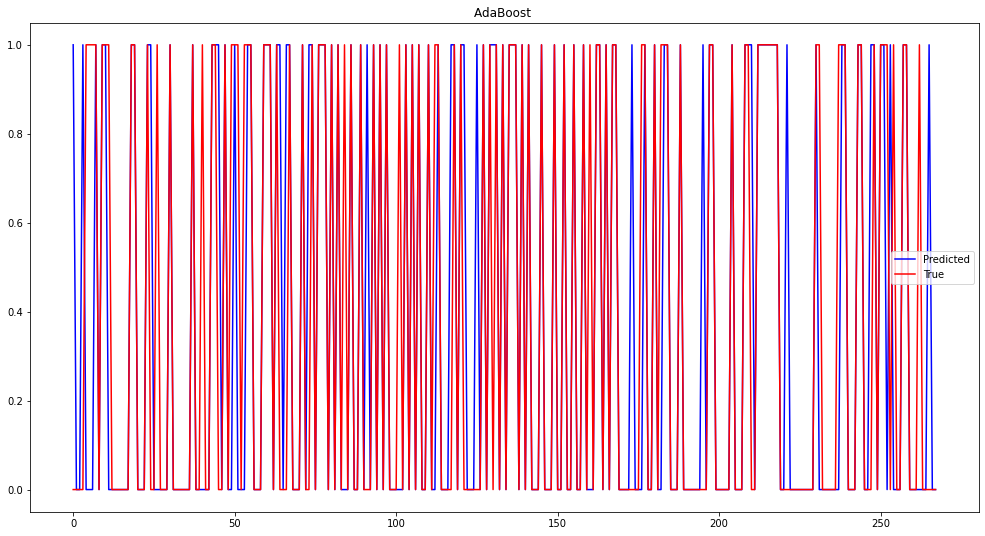

In [ ]:
adaboost(df_train.drop(['Survived'], axis=1),df_train.Survived, isGridSearch=True)

####Without GS
accuracy 0.851

              precision    recall  f1-score   support

           0       0.89      0.86      0.88       164
           1       0.79      0.84      0.81       104

    accuracy                           0.85       268
   macro avg       0.84      0.85      0.84       268
weighted avg       0.85      0.85      0.85       268

    accuracy      0.851


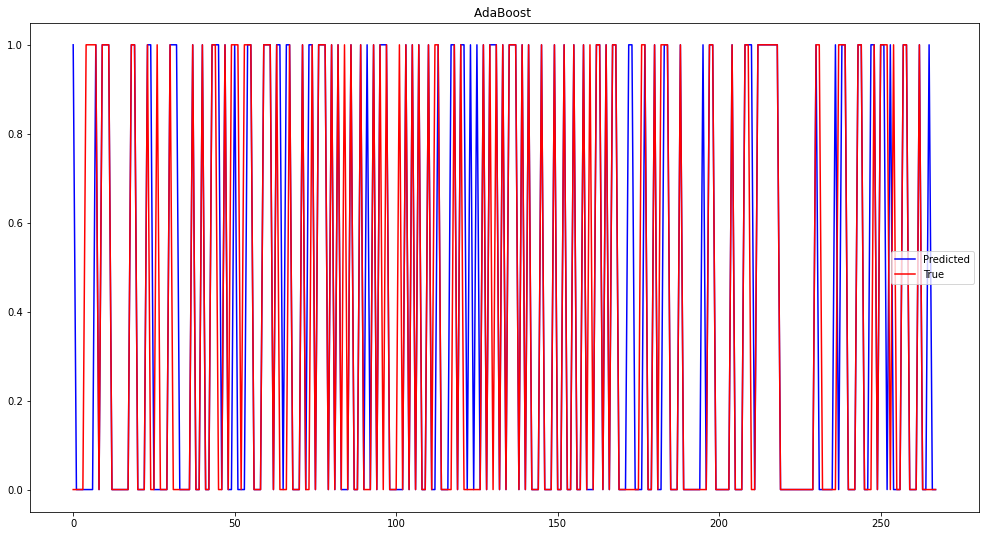

In [ ]:
adaboost(df_train.drop(['Survived'], axis=1),df_train.Survived, isGridSearch=False)

##Results

Okay, just use random forest with deffault conf

In [128]:
X_train = df_train.drop(['Survived'], axis=1)

In [129]:
X_test = prepocesse(pd.read_csv('/content/drive/My Drive/data/titanic/test.csv'))

In [130]:
target_train = df_train.Survived

In [131]:
rf = RandomForestClassifier()
rf.fit(X_train, target_train)
predicted = rf.predict(X_test)

In [132]:
target_test = pd.read_csv('/content/drive/My Drive/data/titanic/gender_submission.csv')
target_test.Survived = predicted

In [133]:
target_test

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [135]:
target_test.to_csv('/content/drive/My Drive/data/titanic/gender_submission.csv')